## Purpose: simple fit example

Artificial data.

Demonstration: 
    1. Linear Model
    2. Parameter fit
    3. Autoscaling, Chisq, Standard deviations
    4. Confidence region for the fit

Author: Do Kester


import classes

In [1]:
import numpy as numpy
import math

from BayesicFitting import PolynomialModel

from BayesicFitting import NestedSampler
from BayesicFitting import GaussPrior
from BayesicFitting import UniformPrior
from BayesicFitting import Tools
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
import matplotlib.pyplot as plt

%matplotlib osx

define some constants

In [22]:
# define some constants
N = 41
b0 = 1.0            # offset of background
b1 = 0.8            # slope of background

sig = 0.5

Make a 1st-degree polynomial

In [23]:
xm = numpy.linspace( -2.0, 5.0, N, dtype=float )
ym = b0 + b1 * xm

numpy.random.seed( 1308 )
y = ym + sig * numpy.random.randn( N )
x = xm + sig * numpy.random.randn( N )

#x = numpy.array( [0,1,9,10], dtype=float )
#y = numpy.array( [1,0,10,9], dtype=float )

Define the model

In [24]:
mdl = PolynomialModel( 1 )
mdl.setLimits( -10, 10 )
#Tools.printclass( mdl )
#problem = ErrorsInXandYProblem( mdl, x, y )

define the fitter: Fitter

+++++++++++++++++++++++++++++++++++++++++++++++++++++++
ErrorsInXandYProblem of Polynomial: f( x:p ) = p_0 + p_1 * x
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
model           Polynomial
npars           43
partype         <class 'float'>
prior           UniformPrior between -3.00 and 6.00
weights         None
xdata           [-1.9526991144027745  -1.9398326494773452  -1.451523799649207  -1.8274123006311567  -0.9232257149396252  -0.3988229374951342  -1.0176911006067222  -0.6766300939007278  ... ]
ydata           [-0.34598348707010523  -0.7330838928693021  -0.32216656170945357  0.2213686911559587  0.8249425186623645  0.6970532437195744  0.14986505770547942  -0.25498753633429716  ... ]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Gauss error distribution
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
deltaP          1e-06
fixed           None
hyperpar        [Noise scale. value = 1.000000  ]
ncalls          0
nparts          0
Fit all parameters of
  Polyn

    7300   -116.2     56.2    -48.5     44  [    1.022    0.726   -2.180   -2.642   -2.747 ...]
    7400   -116.1     56.3    -47.8     44  [    0.829    0.711   -1.681   -2.585   -2.253 ...]
    7500   -116.1     56.3    -47.1     44  [    1.323    0.679   -2.264   -1.181   -2.389 ...]
    7600   -116.1     56.3    -46.5     44  [    0.805    0.726   -1.938   -2.966   -1.427 ...]
    7700   -116.1     56.3    -45.8     44  [    1.031    0.716   -2.120   -2.126   -1.142 ...]
    7800   -116.1     56.4    -45.2     44  [    1.009    0.751   -1.775   -1.636   -1.508 ...]
    7900   -116.1     56.4    -44.5     44  [    1.076    0.710   -2.555   -2.746   -1.710 ...]
    8000   -116.1     56.4    -43.9     44  [    1.158    0.696   -2.243   -2.504   -1.715 ...]
    8100   -116.1     56.4    -43.4     44  [    1.190    0.747   -1.681   -2.621   -2.771 ...]
    8200   -116.1     56.4    -42.9     44  [    0.935    0.630   -2.018   -2.245   -2.091 ...]
    8300   -116.1     56.4    -42.4     

   15900   -116.1     56.4    -22.7     44  [    1.024    0.734   -2.026   -1.918   -1.591 ...]
   16000   -116.1     56.4    -22.6     44  [    1.044    0.733   -1.865   -2.165   -1.612 ...]
   16100   -116.1     56.4    -22.6     44  [    0.971    0.739   -1.967   -2.072   -1.512 ...]
   16200   -116.1     56.4    -22.5     44  [    0.995    0.745   -1.861   -1.991   -1.438 ...]
   16300   -116.1     56.4    -22.5     44  [    0.947    0.732   -1.768   -2.001   -1.522 ...]
   16400   -116.1     56.4    -22.4     44  [    1.003    0.728   -1.990   -2.153   -1.598 ...]
   16500   -116.1     56.4    -22.4     44  [    0.966    0.748   -1.951   -2.014   -1.495 ...]
   16600   -116.1     56.4    -22.4     44  [    1.001    0.738   -1.922   -1.975   -1.664 ...]
   16700   -116.1     56.4    -22.3     44  [    0.922    0.739   -1.973   -1.975   -1.546 ...]
   16800   -116.1     56.4    -22.3     44  [    0.982    0.739   -1.816   -2.206   -1.629 ...]
   16900   -116.1     56.4    -22.3     

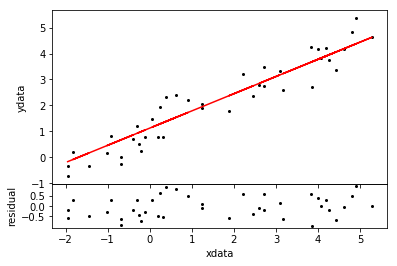

In [25]:
ns = NestedSampler( x, mdl, y, problem="errors", verbose=2, limits=[0.1,1] )
ns.problem.prior = UniformPrior( limits=[-1.0,1.0] )

#Tools.printclass( ns.problem )
#Tools.printclass( ns.distribution )
ns.end = 4.0
ns.verbose = 2

# find the parameters
#keep = {0:0, 1:1, 3:0.5, 4:9.5, 5:9.5}
evid = ns.sample( plot=True )

  

In [29]:
print( "Parameters :", fmt( ns.parameters, max=None ) )
print( "StDevs     :", fmt( ns.stdevs, max=10 ) )
xopt = ns.samples.nuisance
print( "xdata      :", fmt( x, max=10))
print( "Nuisance   :", fmt( xopt, max=10 ) )
print( "StdevNuis  :", fmt( ns.samples.stdevNuis, max=10 ))
print( "Scale      :", fmt( ns.scale ) )


Parameters : [    1.126    0.663]
StDevs     : [    0.229    0.078]
xdata      : [   -1.953   -1.940   -1.452   -1.827   -0.923   -0.399   -1.018   -0.677   -0.680   -0.118 ...]
Nuisance   : [   -1.733   -1.926   -1.551   -1.596   -0.724   -0.380   -1.152   -1.011   -0.971   -0.392 ...]
StdevNuis  : [    0.675    0.623    0.713    0.754    0.740    0.927    0.751    0.704    0.720    0.764 ...]
Scale      :     0.921


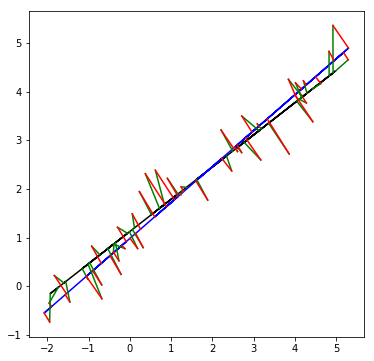

In [27]:
nd = len( x )

xml = ns.samples[-1].nuisance
parml = ns.samples[-1].parameters
yml = mdl.result( xml, parml )
yopt = mdl.result( xopt, ns.parameters )
plt.figure( "Errors in X and Y", figsize=(6,6) )
plt.plot( xopt, yopt, 'k-' )
plt.plot( xml, yml, 'b-' )
for k in range( 0, nd, 1 ):
    # plt.plot( [xm[k],xn[k]], [ym[k],yn[k]], 'b-')
    # plt.plot( [xm[k],x[k]], [ym[k],y[k]], 'r-')
    plt.plot( [x[k],xopt[k]], [y[k],yopt[k]], 'g-')
    plt.plot( [x[k],xml[k]], [y[k],yml[k]], 'r-')
plt.show()

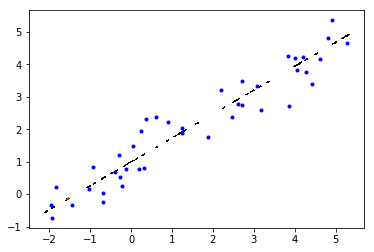

In [28]:
x0 = numpy.zeros( 101, dtype=float )
y0 = numpy.zeros( 101, dtype=float )
k = 0
for w in ns.walkers :
    #print( fmt( w.problem.residuals( w.allpars[:-1] ), max=None ) )
    xx = w.allpars[2:2+nd]
    yy = mdl.result( xx, w.allpars[:2] )
    x0[k] = xx[3]
    y0[k] = yy[3]
    k += 1
    plt.plot( xx, yy, 'k,' )
plt.plot( x0, y0, 'r,' )
plt.plot( x, y, 'b.' )
plt.show()